# Goal: Calculate singles sum $S_i, S_j$

Patricia Schuster  
University of Michigan  
January 11, 2018  

I built the singles histogram in the other methods notebook, `singles_histogram.ipynb`. Now I am going to calculate the sum on that histogram. 

The reason we care about the singles rates:

In order to correct for differences in detection efficiencies and solid angles, we will divide all of the doubles rates by the singles rates of the two detectors as follows:

$ W_{i,j} = \frac{D_{i,j}}{S_i*S_j}$

This requires calculating $S_i$ and $S_j$ from the `cced` files. I need to rewrite my analysis from the beginning, or write another function that parses the `cced` file.

I want to produce a histogram of event rates for each detector vs. $\Delta t$.

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import os
import scipy.io as sio
import sys
import pandas as pd
from tqdm import *

# Plot entire array
np.set_printoptions(threshold=np.nan)

In [2]:
import seaborn as sns
sns.set_palette('spectral')
sns.set_style(style='white')

In [3]:
sys.path.append('../scripts/')
import bicorr as bicorr

In [4]:
%load_ext autoreload
%autoreload 2

In [6]:
det_df = bicorr.load_det_df()
chList, fcList, detList, num_dets, num_det_pairs = bicorr.build_ch_lists()

# Load `singles_histogram` data

I'm going to load it from the combined data sets Cf072115 - Cf072215b. The dimensions of `singles_hist` are:

        Dimension 0: particle type, 0=n, 1=g
        Dimension 1: detector channel
        Dimension 2: dt bin

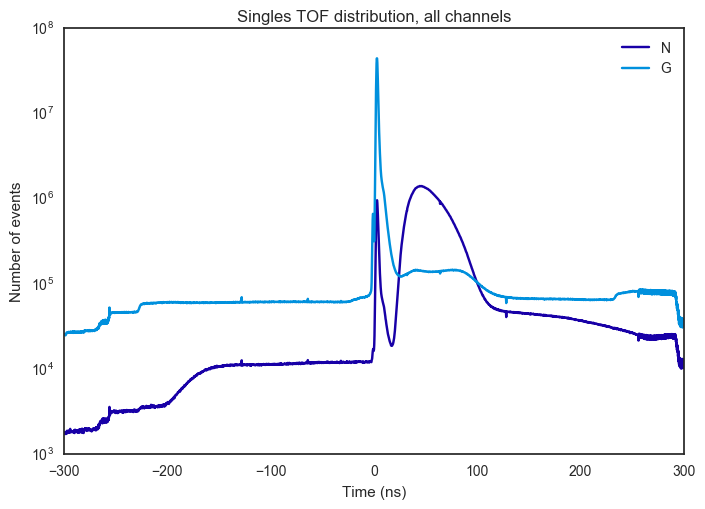

In [10]:
singles_hist, dt_bin_edges_sh, dict_det_to_index = bicorr.load_singles_hist(filepath=r'../analysis/Cf072115_to_Cf072215b/',
                                                                            plot_flag = True, show_flag =True)

# Calculate sum

Follow the same method as in `nn_sum_and_br_subtraction.ipynb`.

## Convert energy to time

In [11]:
emin = 0.62
emax = 12

tmin = bicorr.convert_energy_to_time(emax)
tmax = bicorr.convert_energy_to_time(emin)

print(tmin,tmax)

20.9260185521 92.0622074865


In [15]:
dt_bin_edges_sh[-10:]

array([ 297.75,  298.  ,  298.25,  298.5 ,  298.75,  299.  ,  299.25,
        299.5 ,  299.75,  300.  ])

In [17]:
i_min = np.min(np.argwhere(tmin<dt_bin_edges_sh))
i_max = np.min(np.argwhere(tmax<dt_bin_edges_sh))

print(i_min,i_max)

1284 1569


I also need to find the time ranges for the negative sum.

In [35]:
i_min_neg = np.min(np.argwhere(-tmax<dt_bin_edges_sh))
i_max_neg = np.min(np.argwhere(-tmin<dt_bin_edges_sh))

print(i_min_neg,i_max_neg)

832 1117


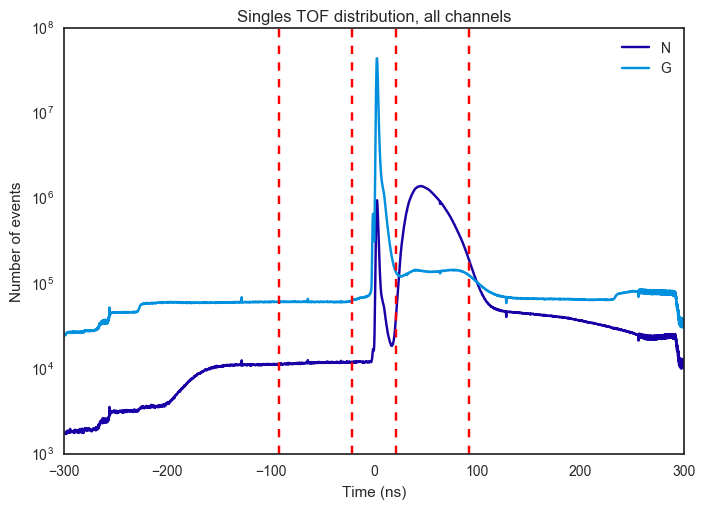

In [40]:
dt_bin_centers = (dt_bin_edges_sh[:-1]+dt_bin_edges_sh[1:])/2
plt.plot(dt_bin_centers,np.sum(singles_hist[0,:,:],axis=(0)))
plt.plot(dt_bin_centers,np.sum(singles_hist[1,:,:],axis=(0)))
plt.axvline(dt_bin_edges_sh[i_min],color='r',linestyle='--')
plt.axvline(dt_bin_edges_sh[i_max],color='r',linestyle='--')
plt.axvline(dt_bin_edges_sh[i_min_neg],color='r',linestyle='--')
plt.axvline(dt_bin_edges_sh[i_max_neg],color='r',linestyle='--')
plt.xlabel('Time (ns)')
plt.ylabel('Number of events')
plt.title('Singles TOF distribution, all channels')
plt.legend(['N','G'])
plt.yscale('log')
plt.show()

## Sum over indices

For this calculation, I am only working with neutron events, so selected 0 in the first dimension of `singles_hist`.

For now, I will use all detector pairs. Start with the positive sum.

In [21]:
np.sum(singles_hist[[0],:,i_min:i_max])

223822908

Now the negative sum

In [41]:
np.sum(singles_hist[[0],:,i_min_neg:i_max_neg])

3370853

For now I am going to limit this to a single detector pair, since at the moment I only envision occasions where I have to calculate the sum for a specific pair and therefore the sums for each detector. 

In [43]:
dict_det_to_index[4]

3

In [44]:
ch_1 = 10
ch_2 = 11

print(np.sum(singles_hist[[0],dict_det_to_index[ch_1],i_min:i_max]))
print(np.sum(singles_hist[[0],dict_det_to_index[ch_2],i_min:i_max]))

4841883
5066259


# Functionalize it

I am going to perform the background subtraction and functionalize this to `bicorr.calc_n_sum_br`. 

In [45]:
help(bicorr.calc_n_sum_br)

Help on function calc_n_sum_br in module bicorr:

calc_n_sum_br(singles_hist, dt_bin_edges_sh, det_i, emin=0.62, emax=12)
    Calculate background-subtracted number of neutron events within a given time range in the singles histogram. Analogous to calc_nn_sum and calc_nn_sum_br for singles events.
    
    NOTE: I AM NOT NORMALIZING THIS. PLAN ACCORDINGLY WHEN USING TOGETHER WITH CALC_NN_SUM
    
    Parameters
    ----------
    singles_hist : ndarray
        Histogram of singles timing information
        Dimension 0: particle type, 0=n, 1=g
        Dimension 1: detector channel
        Dimension 2: dt bin    
    dt_bin_edges_sh : ndarray
        Singles time bin edges array
    det_i : int
        Index of detector in singles_hist. Use dict_det_to_index from `load_singles_hist`
    emin : float
        Lower energy boundary for neutron event selection in MeV
        Default 0.62 MeV ~ 70 keVee
    emax : float, optional
        Upper energy boundary for neutron event selection in M

In [46]:
bicorr.calc_n_sum_br(singles_hist, dt_bin_edges_sh, 1)

(5073249, 2286.2827909075463)

Loop through all of the detectors and calculate it. Populate an array with these values

In [55]:
singles_rates = np.zeros((num_dets,2))
# Dimension 0: Detector index
# Dimension 1: 0- n_sum_br
#              1- n_sum_br_err

In [56]:
for det in detList:
    det_i = dict_det_to_index[det]
    singles_rates[det_i,:] = bicorr.calc_n_sum_br(singles_hist, dt_bin_edges_sh, det_i)

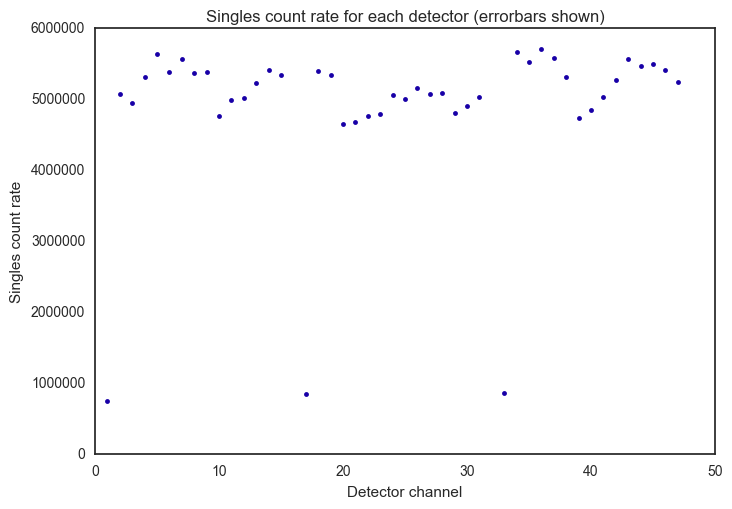

In [61]:
plt.errorbar(detList, singles_rates[:,0], yerr=singles_rates[:,1], fmt='.')
plt.xlabel('Detector channel')
plt.ylabel('Singles count rate')
plt.title('Singles count rate for each detector (errorbars shown)')
plt.show()

I was going to save this to disk, but actually, the singles count rate depends on the timing windows so I need to provide the timing windows. Instead, I'll call the previous loop with the energy windows I desire. 